Cell 1 (imports + DB connection)

In [1]:
from pathlib import Path

import sqlite3 

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (daily time series "price analog")

 - We'll treat daily revenue like a price series

In [3]:
query = """

SELECT
    
    DATE(order_ts) AS day,

    SUM(net_revenue) AS revenue

FROM orders

GROUP BY day

ORDER BY day;

"""

ts = pd.read_sql_query(query, conn)

ts["day"] = pd.to_datetime(ts["day"])

ts = ts.set_index("day")

ts.head()

,revenue
day,
2024-01-01,1422.22
2024-01-02,1456.57
2024-01-03,1459.21
2024-01-04,2009.31
2024-01-05,1429.87


Cell 3 (create "returns")

  - Backtests operate on changes, not levels.
  - This is the return stream.

In [5]:
ts["returns"] = ts["revenue"].pct_change()

ts.dropna(inplace=True)

ts.head()

,revenue,returns
day,,
2024-01-02,1456.57,0.024152
2024-01-03,1459.21,0.001812
2024-01-04,2009.31,0.376985
2024-01-05,1429.87,-0.288378
2024-01-06,1428.31,-0.001091


Cell 4 (define simple strategy "moving average crossover")

  - RULE:
  - Long when short MA > long MA
  - Flat otherwise

In [14]:
short_window = 5

long_window = 20

ts["ma_short"] = ts["revenue"].rolling(short_window).mean()

ts["ma_long"] = ts["revenue"].rolling(long_window).mean()

ts.dropna(inplace=True)

ts["signal"].value_counts(), ts[["ma_short", "ma_long", "signal"]].tail()

(signal
 0    361
 1    329
 Name: count, dtype: int64,
             ma_short    ma_long  signal
 day                                    
 2025-12-26  2180.570  1901.5900       1
 2025-12-27  2235.156  1906.5145       1
 2025-12-28  2147.222  1906.8645       1
 2025-12-29  2300.018  1950.6290       1
 2025-12-30  2171.258  1871.4120       1)

Cell 5 (generate signals)
  
  - 1 --> in the market
  - 0 --> out of the market

In [15]:
ts["signal"] = 0

ts.loc[ts["ma_short"] > ts["ma_long"], "signal"] = 1

ts[["revenue", "ma_short", "ma_long"]].tail()

,revenue,ma_short,ma_long
day,,,
2025-12-26,1984.53,2180.570,1901.5900
2025-12-27,3172.02,2235.156,1906.5145
2025-12-28,1850.50,2147.222,1906.8645
2025-12-29,2913.38,2300.018,1950.6290
2025-12-30,935.86,2171.258,1871.4120


Cell 6 (apply the strategy)

  - Shift the signal to avoid lookahead bias.
  - Golden Rule: Never trade on information from the same bar.
  - This alone seperates ameteurs from professionals.

In [16]:
ts["strategy_returns"] = ts["signal"].shift(1) * ts["returns"]

ts.dropna(inplace=True)

ts[["returns", "signal", "strategy_returns"]].tail()

,returns,signal,strategy_returns
day,,,
2025-12-26,0.256302,1,0.256302
2025-12-27,0.598373,1,0.598373
2025-12-28,-0.416618,1,-0.416618
2025-12-29,0.574374,1,0.574374
2025-12-30,-0.678772,1,-0.678772


Cell 7 (evaluate performance)

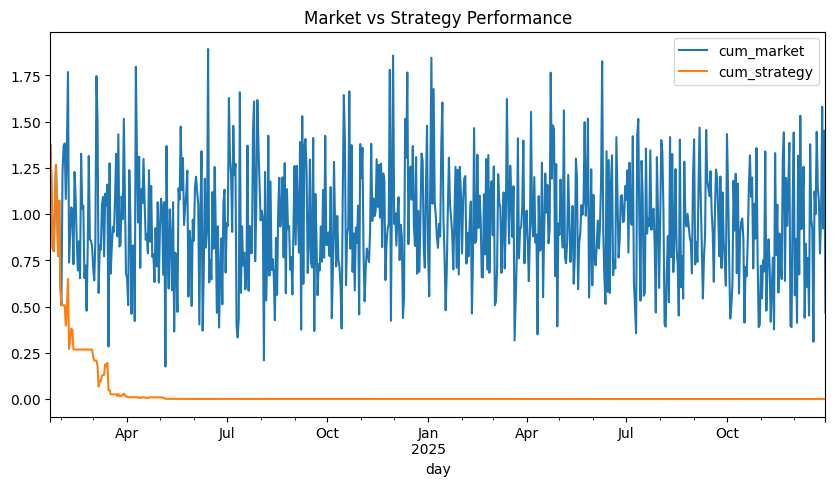

In [9]:
ts["cum_market"] = (1 + ts["returns"]).cumprod()

ts["cum_strategy"] = (1 + ts["strategy_returns"]).cumprod()

ts[["cum_market", "cum_strategy"]].plot(

    title="Market vs Strategy Performance",

    figsize=(10, 5)

)

plt.show()

Cell 8 (basic metrics)


In [12]:
def sharpe(returns):

    return returns.mean() / returns.std()

market_sharpe = sharpe(ts["returns"])

strategy_sharpe = sharpe(ts["strategy_returns"])

market_sharpe, strategy_sharpe

(np.float64(0.20601981772677713), np.float64(-0.028533598500304944))

Cell 9 (drawdown)

In [13]:
ts["strategy_peak"] = ts["cum_strategy"].cummax()

ts["drawdown"] = ts["cum_strategy"] / ts["strategy_peak"] - 1

ts["drawdown"].min()

np.float64(-1.0)

## Day 7 - Backtesting Insights

  - Simple moving average rules can be formally evaluated usinng historical data.
  - Signal shifting is essential to avoid lookahead bias.
  - Srategy performance must be compared to a baselin (market).
  - Risk metriccs such as drawdown and sharpe like ratios provide necessary context.
  - A profitable backtest does not imply robustness or future success.

  Backtesting is a hypothesis testing tool, not a guarantee.